# Presentation

In this notebook we explore 1D optimal transport by computing the barycenter between spectra. 

We'll first explore 1D OT on gaussians followed by 1D OT on pure sine waves. In the end we explore this method on real signals.

We'll compute barycenters using 3 functions:

* Quantile method   
* Entropic barycenter 
* Regularized sinkhorn

In [248]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

from utils import *


## OT between diracs

In this part we compute 1D Optimal transport between diracs


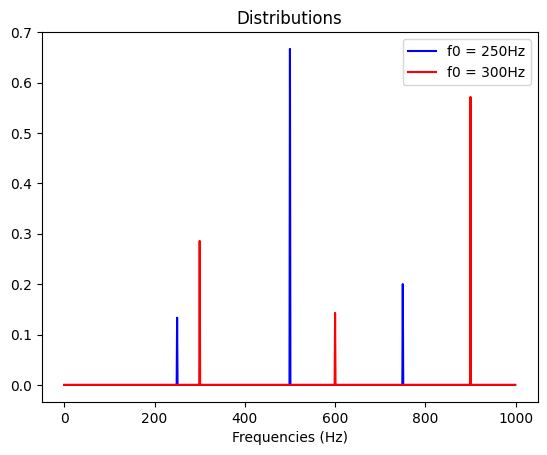

In [249]:
# Define dirac distributions

n = 1000

f1 = n * 0.25
f2 = n * 0.3

a1 = dirac_distribution([f1, f1*2, f1*3], [0.2, 1, 0.3], n=n)
a2 = dirac_distribution([f2, f2*2, f2*3], [1, 0.5, 2], n=n)

frequencies = np.arange(n)

plt.plot(frequencies, a1, color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(frequencies, a2, color="red", label=f"f0 = {f2:.0f}Hz")
plt.title('Distributions')
plt.xlabel("Frequencies (Hz)")
plt.legend()

plt.show()

# for other example

# _a1 = dirac_distribution([f1, f1*2], [0.2, 1])
# _a2 = dirac_distribution([f2, f2*2], [1, 0.5])

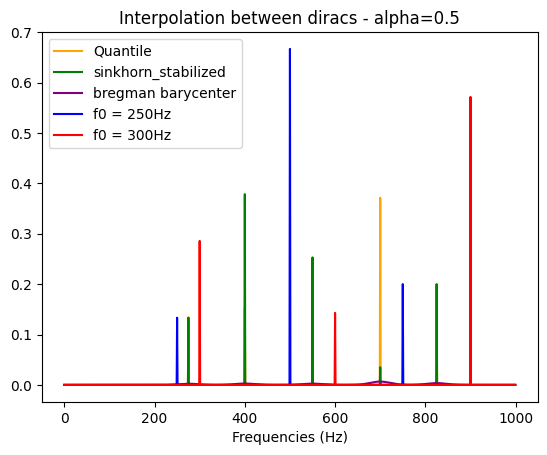

In [269]:
# Optimal transport

alpha = 0.5

# Quantile method 

quantile_interpolation = quantile_optimal_transport(a1, a2, alpha=alpha)

# ot.bregman.sinkhorn_stabilized

M = ot.utils.dist0(n) # cost matrix
M /= M.max()
ss_reg = 1e-2

ot_plan = ot.bregman.sinkhorn_stabilized(a1, a2, M, ss_reg)

ss_interpolation = np.zeros(n)
for i in range(n):
    for j in range(n):
        alpha_index = get_frequency(i, j, alpha=alpha, method='int')
        ss_interpolation[index] += ot_plan[i][j]
ss_interpolation /= np.sum(ss_interpolation)

# ot.bregman.barycenter

A = np.vstack((a1, a2)).T
weights = np.array([1 - alpha, alpha])
bb_reg = 1e-3
bregman_interpolation = ot.bregman.barycenter(A, M, bb_reg, weights)


plt.plot(frequencies, quantile_interpolation, label='Quantile', color="orange")
plt.plot(frequencies, ss_interpolation, label='sinkhorn_stabilized', color="green")
plt.plot(frequencies, bregman_interpolation, label='bregman barycenter', color="purple")
plt.plot(frequencies, a1, label=f"f0 = {f1:.0f}Hz", color="blue")
plt.plot(frequencies, a2, label=f"f0 = {f2:.0f}Hz", color="red")
plt.xlabel("Frequencies (Hz)")
plt.title(f"Interpolation between diracs - alpha={alpha}")
plt.legend()
plt.show()


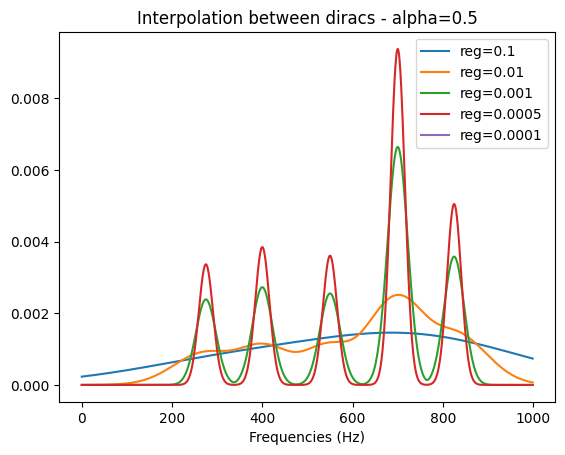

(array([0.        , 0.13333333, 0.2       , 0.66666667]), array([997,   1,   1,   1], dtype=int64))
(array([0.00000000e+00, 1.08815235e-15, 1.90289788e-13, 2.64595538e-08,
       4.28539257e-07, 3.50590563e-02, 1.33333307e-01, 1.99999571e-01,
       2.53062271e-01, 3.78545339e-01]), array([991,   1,   1,   1,   1,   1,   1,   1,   1,   1], dtype=int64))
[(275, 0.13333330687377842), (400, 0.37854533917033445), (425, 2.6459553802709235e-08), (525, 1.9028978793602833e-13), (550, 0.2530622712148008), (575, 1.0881523492448141e-15), (675, 4.28539257341359e-07), (700, 0.03505905628153136), (825, 0.19999957146055247)]


In [288]:
## SLIDES - PLOTS

# A = np.vstack((a1, a2)).T
# weights = np.array([1 - alpha, alpha])
# bb_regs = [1e-1, 1e-2, 1e-3, 5e-4, 1e-4]
# bregman_interpolations = [ot.bregman.barycenter(A, M, bb_reg, weights) for bb_reg in bb_regs]

# for i, bregman_interpolation in enumerate(bregman_interpolations):
#     plt.plot(frequencies, bregman_interpolation, label=f"reg={bb_regs[i]}")


# # plt.plot(frequencies, quantile_interpolation, label='Quantile', color="orange")
# # plt.plot(frequencies, ss_interpolation, label='sinkhorn_stabilized', color="green")
# # plt.plot(frequencies, bregman_interpolation * 100, label='bregman barycenter * 100', color="purple")
# # plt.plot(frequencies, a1, label=f"f0 = {f1:.0f}Hz", color="blue")
# # plt.plot(frequencies, a2, label=f"f0 = {f2:.0f}Hz", color="red")
# plt.xlabel("Frequencies (Hz)")
# plt.title(f"Interpolation between diracs - alpha={alpha}")
# plt.legend()
# plt.show()

# print(np.unique(a1, return_counts=True))
# print(np.unique(ss_interpolation, return_counts=True))

# non_zero_values_and_indices = [(i, val) for i, val in enumerate(ss_interpolation) if val != 0]
# print(non_zero_values_and_indices)


## OT between gaussians

In this part we compute 1D Optimal transport between two gaussian distributions.


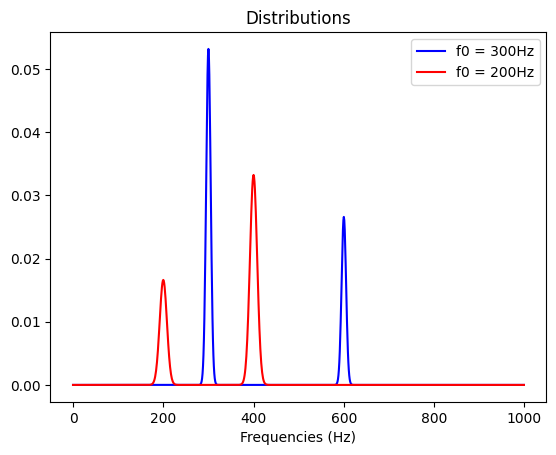

In [289]:
# We compute two 1000-bins gaussian distributions with different mean and std

n = 1000
x = np.arange(n, dtype=np.float64)

f1 = n * 0.3
f2 = n * 0.2
s1 = n * 0.005
s2 = n * 0.008

# Gaussian distributions
a1 = 1.0 * ot.datasets.make_1D_gauss(n, m=f1, s=s1) + 0.5 * ot.datasets.make_1D_gauss(n, m=f1*2, s=s1)
a1 = a1 / np.sum(a1)
a2 = 0.5 * ot.datasets.make_1D_gauss(n, m=f2, s=s2) + 1.0 * ot.datasets.make_1D_gauss(n, m=f2*2, s=s2)
a2 = a2 / np.sum(a2)

plt.plot(x, a1, color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(x, a2, color="red", label=f"f0 = {f2:.0f}Hz")
plt.title('Distributions')
plt.xlabel("Frequencies (Hz)")
plt.legend()


plt.show()


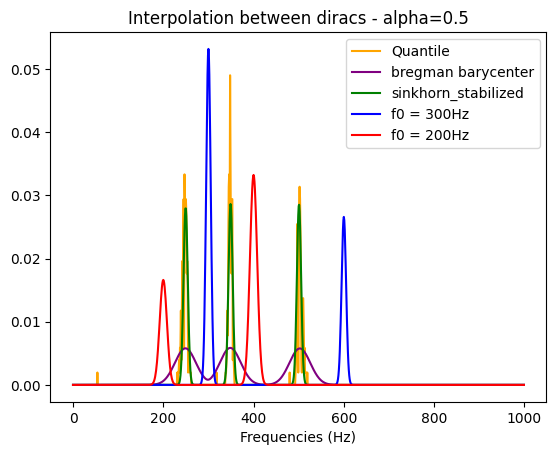

In [304]:
# Optimal transport

alpha = 0.5

# Quantile method 

quantile_interpolation = quantile_optimal_transport(a1, a2, alpha=alpha)

# ot.bregman.sinkhorn_stabilized

M = ot.utils.dist0(n) # cost matrix
M /= M.max()
reg = 1e-2

ot_plan = ot.bregman.sinkhorn_stabilized(a1, a2, M, reg)

ss_interpolation = np.zeros(n)
for i in range(n):
    for j in range(n):
        index = get_frequency(i, j, alpha=alpha, method='int')
        ss_interpolation[index] += ot_plan[i][j]
ss_interpolation /= np.sum(ss_interpolation)

# ot.bregman.barycenter

A = np.vstack((a1, a2)).T
weights = np.array([1 - alpha, alpha])
bb_reg = 1e-3
bregman_interpolation = ot.bregman.barycenter(A, M, bb_reg, weights)

plt.plot(frequencies, quantile_interpolation, label='Quantile', color="orange")
plt.plot(frequencies, bregman_interpolation, label='bregman barycenter', color="purple")
plt.plot(frequencies, ss_interpolation, label='sinkhorn_stabilized', color="green")
plt.plot(frequencies, a1, label=f"f0 = {f1:.0f}Hz", color="blue")
plt.plot(frequencies, a2, label=f"f0 = {f2:.0f}Hz", color="red")
plt.xlabel("Frequencies (Hz)")
plt.title(f"Interpolation between diracs - alpha={alpha}")
plt.legend()
plt.show()


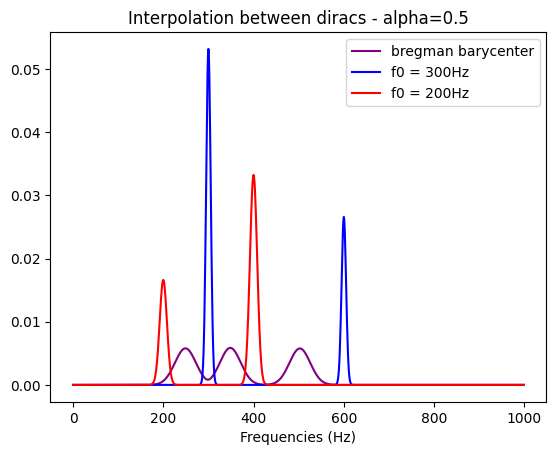

(array([0.00000000e+000, 1.72922976e-322, 3.40905296e-322, 3.58825057e-319,
       7.17645173e-319, 7.31480705e-316, 1.46296141e-315, 1.43269929e-312,
       2.86539858e-312, 2.69609654e-309, 5.39219308e-309, 4.87465690e-306,
       9.74931379e-306, 8.46800076e-303, 1.69360015e-302, 1.41333770e-299,
       2.82667540e-299, 2.26641388e-296, 4.53282775e-296, 3.49189131e-293,
       6.98378263e-293, 5.16904646e-290, 1.03380929e-289, 7.35171012e-287,
       1.47034202e-286, 1.00460315e-283, 2.00920629e-283, 1.31895177e-280,
       2.63790353e-280, 1.66376320e-277, 3.32752640e-277, 2.01642622e-274,
       4.03285244e-274, 2.34801776e-271, 4.69603553e-271, 2.62693085e-268,
       5.25386170e-268, 2.82373622e-265, 5.64747244e-265, 2.91627066e-262,
       5.83254133e-262, 2.89374164e-259, 5.78748329e-259, 2.75879798e-256,
       5.51759597e-256, 2.52701760e-253, 5.05403520e-253, 2.22394916e-250,
       4.44789831e-250, 1.88048408e-247, 3.76096817e-247, 1.52771622e-244,
       3.05543245e-244, 

In [305]:
## SLIDES - PLOTS

# # A = np.vstack((a1, a2)).T
# # weights = np.array([1 - alpha, alpha])
# # bb_regs = [1e-1, 1e-2, 1e-3, 5e-4, 1e-4]
# # bregman_interpolations = [ot.bregman.barycenter(A, M, bb_reg, weights) for bb_reg in bb_regs]

# # for i, bregman_interpolation in enumerate(bregman_interpolations):
# #     plt.plot(frequencies, bregman_interpolation, label=f"reg={bb_regs[i]}")


# # plt.plot(frequencies, quantile_interpolation, label='Quantile', color="orange")
# # plt.plot(frequencies, ss_interpolation, label='sinkhorn_stabilized', color="green")
# plt.plot(frequencies, bregman_interpolation, label='bregman barycenter', color="purple")
# plt.plot(frequencies, a1, label=f"f0 = {f1:.0f}Hz", color="blue")
# plt.plot(frequencies, a2, label=f"f0 = {f2:.0f}Hz", color="red")
# plt.xlabel("Frequencies (Hz)")
# plt.title(f"Interpolation between diracs - alpha={alpha}")
# plt.legend()
# plt.show()

# print(np.unique(a1, return_counts=True))
# print(np.unique(ss_interpolation, return_counts=True))

# non_zero_values_and_indices = [(i, val) for i, val in enumerate(ss_interpolation) if val != 0]
# print(non_zero_values_and_indices)


# On an artificial signal

In [448]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.5
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A4_freq = 440
A4_signal = np.sin(2 * np.pi * A4_freq * frames)
A4_signal[:smooth_len] *= smoothing
A4_signal[-smooth_len:] *= np.flip(smoothing)

C5_freq = 1046.5
C5_signal = np.sin(2 * np.pi * C5_freq * frames)
C5_signal[:smooth_len] *= smoothing
C5_signal[-smooth_len:] *= np.flip(smoothing)

n_fft = 1024
A4_fft = librosa.stft(A4_signal, n_fft=n_fft)
C5_fft = librosa.stft(C5_signal, n_fft=n_fft)

freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)


In [450]:
# Optimal transport

signals = []
# alpha_arr = np.linspace(0, 1, 2) # compute OT for multiple values of alpha
alpha_arr = [0.5]

quantile_interpolations = []
ss_interpolations = []
bb_interpolations = []

for alpha in alpha_arr:
    quantile_interpolated_frames = []
    ss_interpolated_frames = []

    bb_regs = [1e-1, 1e-2, 1e-3, 5e-4, 1e-4]
    bb_interpolated_frames = [[] for _ in range(len(bb_regs))]

    for index in range(A4_fft.shape[1]):
        if(index % 10 == 0):
            print(f"At frame {index}")

        # Retrieving current amplitude stft's normalized frame and relative amplitude 

        A_frame = A4_fft[:,index]
        A_frame = np.abs(A_frame)
        A_frame_relative_amplitude = np.sum(A_frame)
        A_frame = A_frame / np.sum(A_frame)
        C_frame = C5_fft[:,index]
        C_frame = np.abs(C_frame)
        C_frame_relative_amplitude = np.sum(C_frame)
        C_frame = C_frame / np.sum(C_frame)

        interpolated_frame_relative_amplitude = (1-alpha) * A_frame_relative_amplitude + alpha * C_frame_relative_amplitude

        # Quantile method
        quantile_interpolation_frame = quantile_optimal_transport(A_frame, C_frame, alpha=alpha)
        quantile_interpolation_frame *= interpolated_frame_relative_amplitude
        quantile_interpolated_frames.append(quantile_interpolation_frame)

        # ot.sinkhorn_stabilized
        n = len(A_frame)
        M = ot.utils.dist0(n) # cost matrix
        M /= M.max()
        reg = 1e-2

        ot_plan = ot.bregman.sinkhorn_stabilized(A_frame, C_frame, M, reg)

        ss_interpolated_frame = np.zeros(n)
        for i in range(n):
            for j in range(n):
                index = get_frequency(i, j, alpha=alpha, method='int')
                ss_interpolated_frame[index] += ot_plan[i][j]
        ss_interpolated_frame /= np.sum(ss_interpolated_frame)
        ss_interpolated_frame *= interpolated_frame_relative_amplitude
        ss_interpolated_frames.append(ss_interpolated_frame)

        # ot.bregman.barycenter

    
        A = np.vstack((A_frame, C_frame)).T
        weights = np.array([1 - alpha, alpha])
        bregman_interpolated_frames = np.array([ot.bregman.barycenter(A, M, bb_reg, weights) for bb_reg in bb_regs])
        bregman_interpolated_frames *= interpolated_frame_relative_amplitude

        for i in range(len(bregman_interpolated_frames)):
            bb_interpolated_frames[i].append(bregman_interpolated_frames[i])

    quantile_interpolations.append(np.array(quantile_interpolated_frames))
    ss_interpolations.append(np.array(ss_interpolated_frames))
    bb_interpolations.append(np.array(bb_interpolated_frames))

quantile_interpolations = np.array([signal.T for signal in quantile_interpolations])
ss_interpolations = np.array([signal.T for signal in ss_interpolations])
bb_interpolations = np.array([np.array([signal.T for signal in regs]) for regs in bb_interpolations])


At frame 0
At frame 10
At frame 20
At frame 30
At frame 40
At frame 50
At frame 60
At frame 70
At frame 80


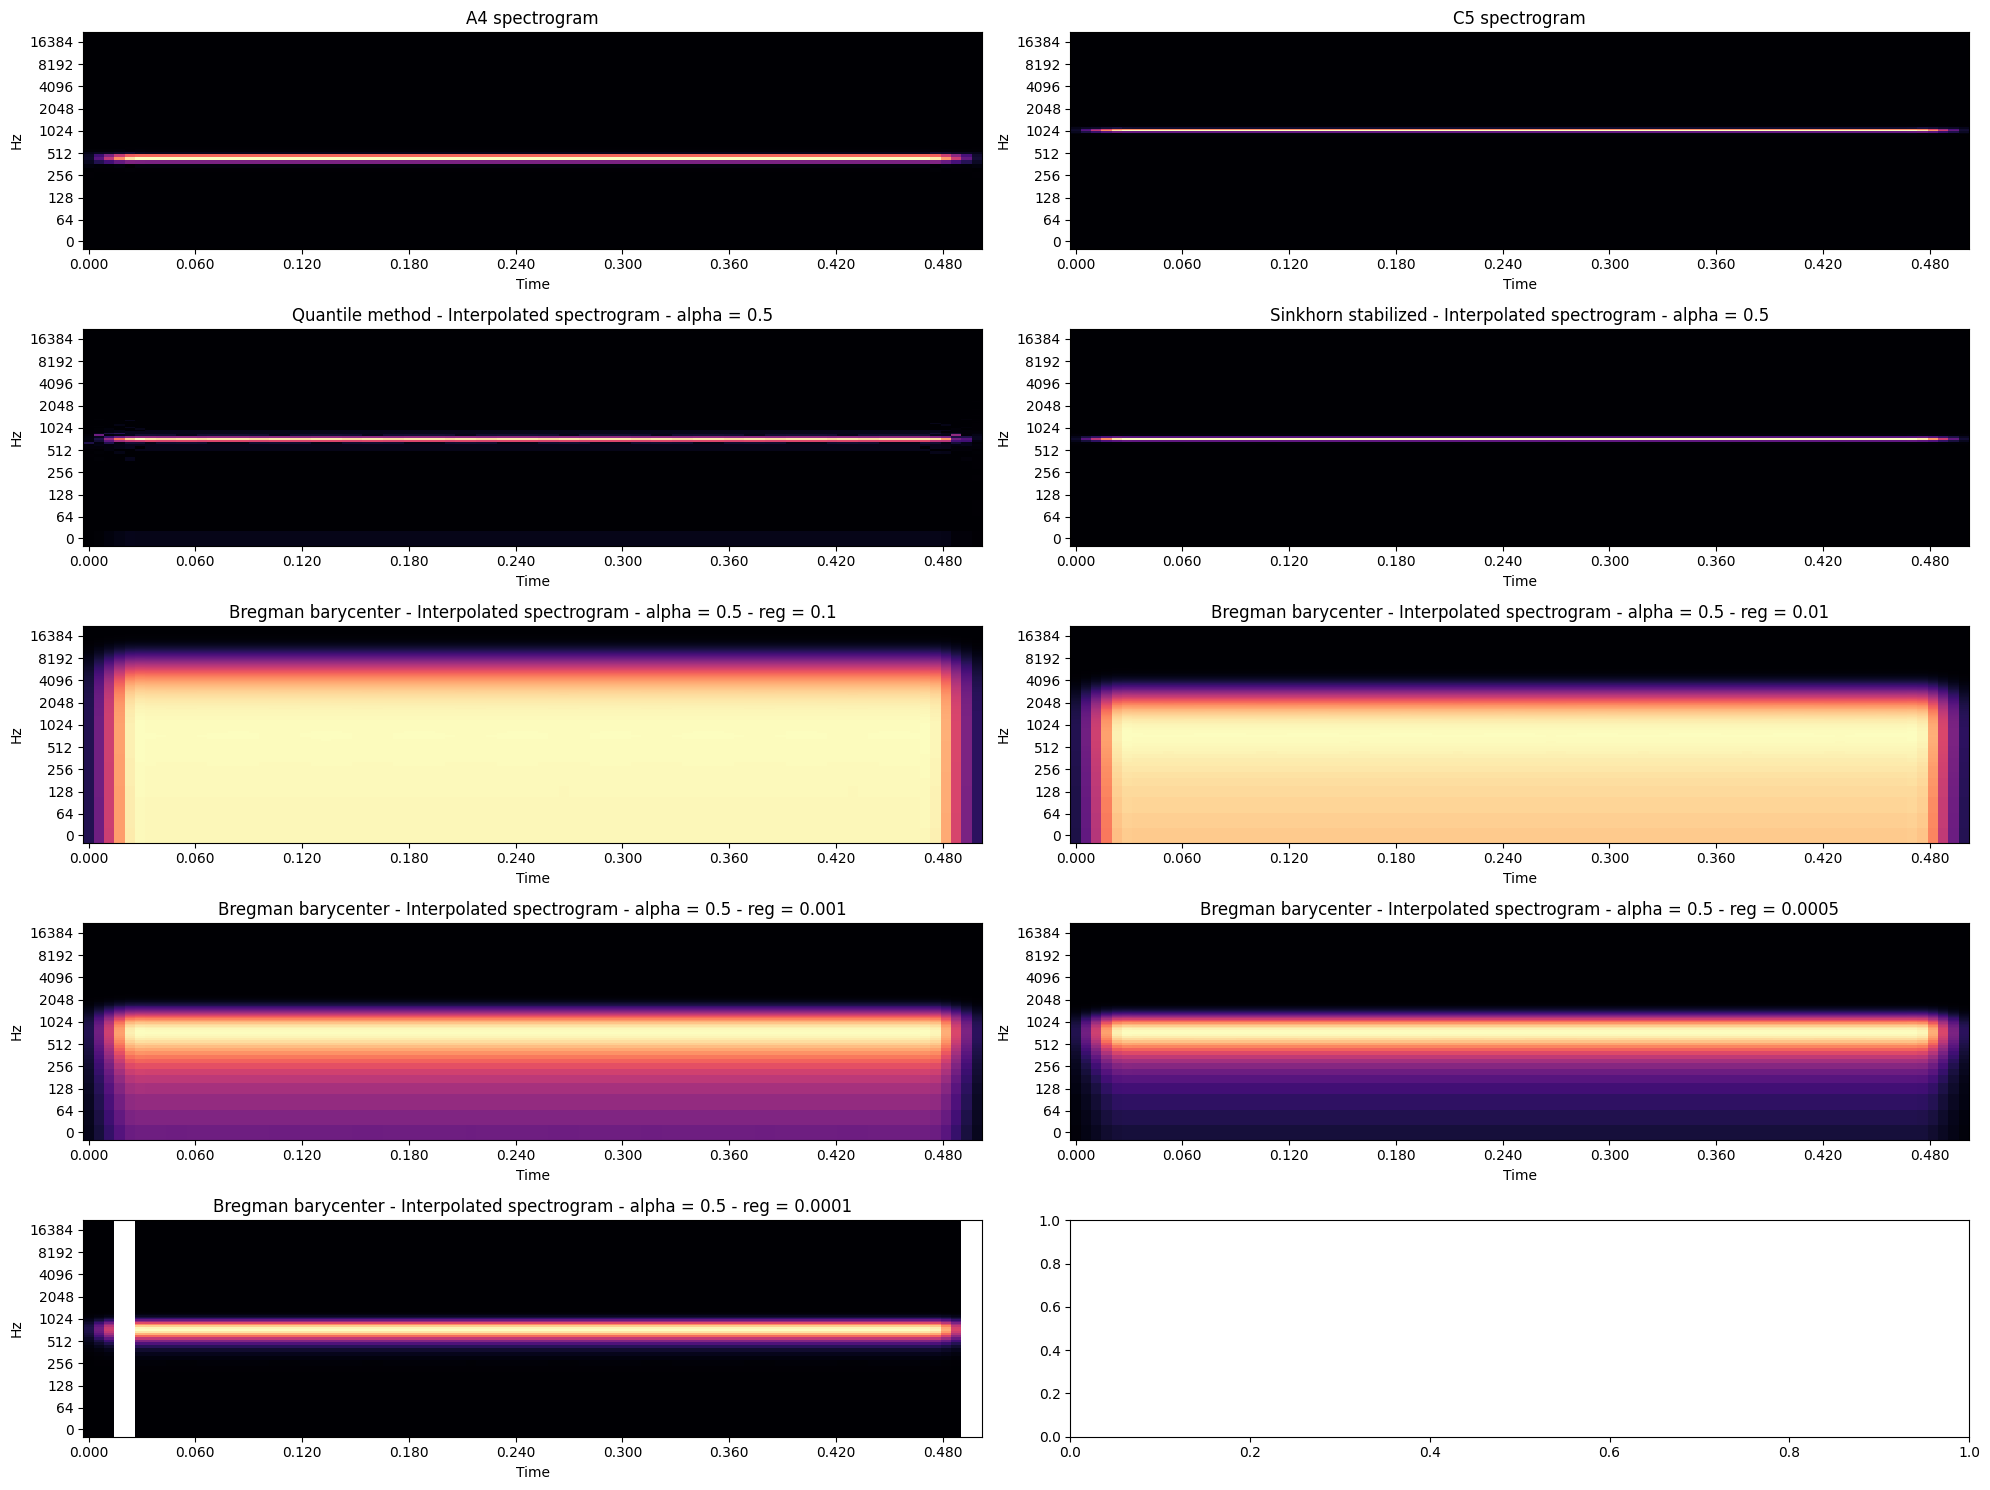

In [451]:
index = 0
quantile_interpolation = quantile_interpolations[index]
ss_interpolation = ss_interpolations[index]
bb_interpolation = bb_interpolations[index]

fig, ax = plt.subplots(2 + len(bb_regs)//2 + 1, 2, figsize=(20, 15))

librosa.display.specshow(np.abs(A4_fft), y_axis='log', x_axis='time', ax=ax[0][0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(np.abs(C5_fft), y_axis='log', x_axis='time', ax=ax[0][1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(np.abs(quantile_interpolation), y_axis='log', x_axis='time', ax=ax[1][0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(np.abs(ss_interpolation), y_axis='log', x_axis='time', ax=ax[1][1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)

ax[0][0].set_title(f'A4 spectrogram')
ax[0][1].set_title(f'C5 spectrogram')
ax[1][0].set_title(f'Quantile method - Interpolated spectrogram - alpha = {alpha_arr[index]}')
ax[1][1].set_title(f'Sinkhorn stabilized - Interpolated spectrogram - alpha = {alpha_arr[index]}')

for i, spec in enumerate(bb_interpolations[index]):
    librosa.display.specshow(np.abs(spec), y_axis='log', x_axis='time', ax=ax[2+i//2][i%2], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
    ax[2+i//2][i%2].set_title(f'Bregman barycenter - Interpolated spectrogram - alpha = {alpha_arr[index]} - reg = {bb_regs[i]}')

plt.tight_layout()

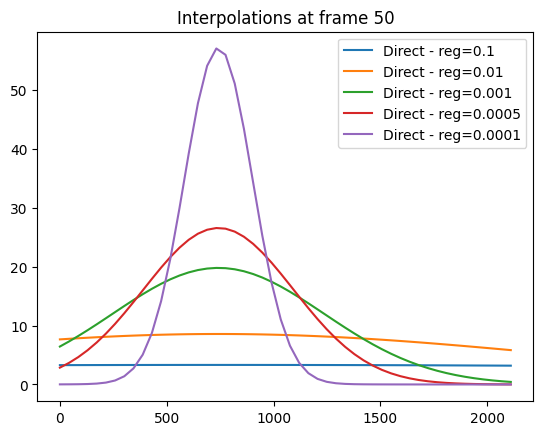

In [468]:
## SLIDES - PLOTS

# alpha_index = 0
# quantile_interpolation = quantile_interpolations[alpha_index]
# ss_interpolation = ss_interpolations[alpha_index]
# bb_interpolation = bb_interpolations[alpha_index]
# frame = 50

# n_frames = 50

# # plt.plot(freqs[:n_frames], np.abs(A4_fft[:, frame][:n_frames]), label=f"A4")
# # plt.plot(freqs[:n_frames], np.abs(C5_fft[:, frame][:n_frames]), label=f"C6")
# # plt.plot(freqs[:n_frames], np.abs(quantile_interpolation[:, frame][:n_frames]), label=f"Quantile")
# # plt.plot(freqs[:n_frames], np.abs(ss_interpolation[:, frame][:n_frames]), label=f"Sinkhorn stabilized")

# for i, spec in enumerate(bb_interpolation):
#     plt.plot(freqs[:n_frames], np.abs(spec[:, frame][:n_frames]), label=f"Direct - reg={bb_regs[i]}")

# plt.legend()
# plt.title(f"Interpolations at frame {frame}")  
# plt.show()  

In [453]:
index = 0
quantile_interpolation = quantile_interpolations[index]
ss_interpolation = ss_interpolations[index]
bb_interpolation = bb_interpolations[index]

quantile_inversed = librosa.griffinlim(quantile_interpolation, n_iter=100)
ss_inversed = librosa.griffinlim(ss_interpolation, n_iter=100)
bb_inversed = [librosa.griffinlim(bb_interpolation[i], n_iter=100) for i in range(len(bb_interpolation) - 1)]
audio_widgets = []

title = widgets.Label(f'A4')
audio_player = IPython.display.Audio(data=A4_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C5')
audio_player = IPython.display.Audio(data=C5_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Quantile interpolation - alpha={alpha_arr[index]}')
audio_player = IPython.display.Audio(data=quantile_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Sinkhorn interpolation - alpha={alpha_arr[index]}')
audio_player = IPython.display.Audio(data=ss_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

for i, reg_interpolation in enumerate(bb_inversed): 
    title = widgets.Label(f'Bregman barycenter interpolation - alpha={alpha_arr[index]} - reg={bb_regs[i]}')
    audio_player = IPython.display.Audio(data=reg_interpolation, rate=sr)
    out = widgets.Output()
    with out:
        display(audio_player)
    combined_widget = widgets.VBox([title, out])
    audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

# On a real signal

In [469]:
duration = 0.3 # in seconds

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)


A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)

n_fft = 1024
A_fft = librosa.stft(A_signal, n_fft=n_fft)
C_fft = librosa.stft(C_signal, n_fft=n_fft)

freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)


In [470]:
# Optimal transport

signals = []
# alpha_arr = np.linspace(0, 1, 2) # compute OT for multiple values of alpha
alpha_arr = [0.5]

quantile_interpolations = []
ss_interpolations = []
bb_interpolations = []

for alpha in alpha_arr:
    quantile_interpolated_frames = []
    ss_interpolated_frames = []

    bb_regs = [1e-1, 1e-2, 1e-3, 5e-4, 1e-4]
    bb_interpolated_frames = [[] for _ in range(len(bb_regs))]

    for index in range(A_fft.shape[1]):
        if(index % 10 == 0):
            print(f"At frame {index}")

        # Retrieving current amplitude stft's normalized frame and relative amplitude 

        A_frame = A_fft[:,index]
        A_frame = np.abs(A_frame)
        A_frame_relative_amplitude = np.sum(A_frame)
        A_frame = A_frame / np.sum(A_frame)
        C_frame = C_fft[:,index]
        C_frame = np.abs(C_frame)
        C_frame_relative_amplitude = np.sum(C_frame)
        C_frame = C_frame / np.sum(C_frame)

        interpolated_frame_relative_amplitude = (1-alpha) * A_frame_relative_amplitude + alpha * C_frame_relative_amplitude

        # Quantile method
        quantile_interpolation_frame = quantile_optimal_transport(A_frame, C_frame, alpha=alpha)
        quantile_interpolation_frame *= interpolated_frame_relative_amplitude
        quantile_interpolated_frames.append(quantile_interpolation_frame)

        # ot.sinkhorn_stabilized
        n = len(A_frame)
        M = ot.utils.dist0(n) # cost matrix
        M /= M.max()
        reg = 1e-2

        ot_plan = ot.bregman.sinkhorn_stabilized(A_frame, C_frame, M, reg)

        ss_interpolated_frame = np.zeros(n)
        for i in range(n):
            for j in range(n):
                index = get_frequency(i, j, alpha=alpha, method='int')
                ss_interpolated_frame[index] += ot_plan[i][j]
        ss_interpolated_frame /= np.sum(ss_interpolated_frame)
        ss_interpolated_frame *= interpolated_frame_relative_amplitude
        ss_interpolated_frames.append(ss_interpolated_frame)

        # ot.bregman.barycenter

    
        A = np.vstack((A_frame, C_frame)).T
        weights = np.array([1 - alpha, alpha])
        bregman_interpolated_frames = np.array([ot.bregman.barycenter(A, M, bb_reg, weights) for bb_reg in bb_regs])
        bregman_interpolated_frames *= interpolated_frame_relative_amplitude

        for i in range(len(bregman_interpolated_frames)):
            bb_interpolated_frames[i].append(bregman_interpolated_frames[i])

    quantile_interpolations.append(np.array(quantile_interpolated_frames))
    ss_interpolations.append(np.array(ss_interpolated_frames))
    bb_interpolations.append(np.array(bb_interpolated_frames))

quantile_interpolations = np.array([signal.T for signal in quantile_interpolations])
ss_interpolations = np.array([signal.T for signal in ss_interpolations])
bb_interpolations = np.array([np.array([signal.T for signal in regs]) for regs in bb_interpolations])


At frame 0
At frame 10
At frame 20
At frame 30
At frame 40
At frame 50


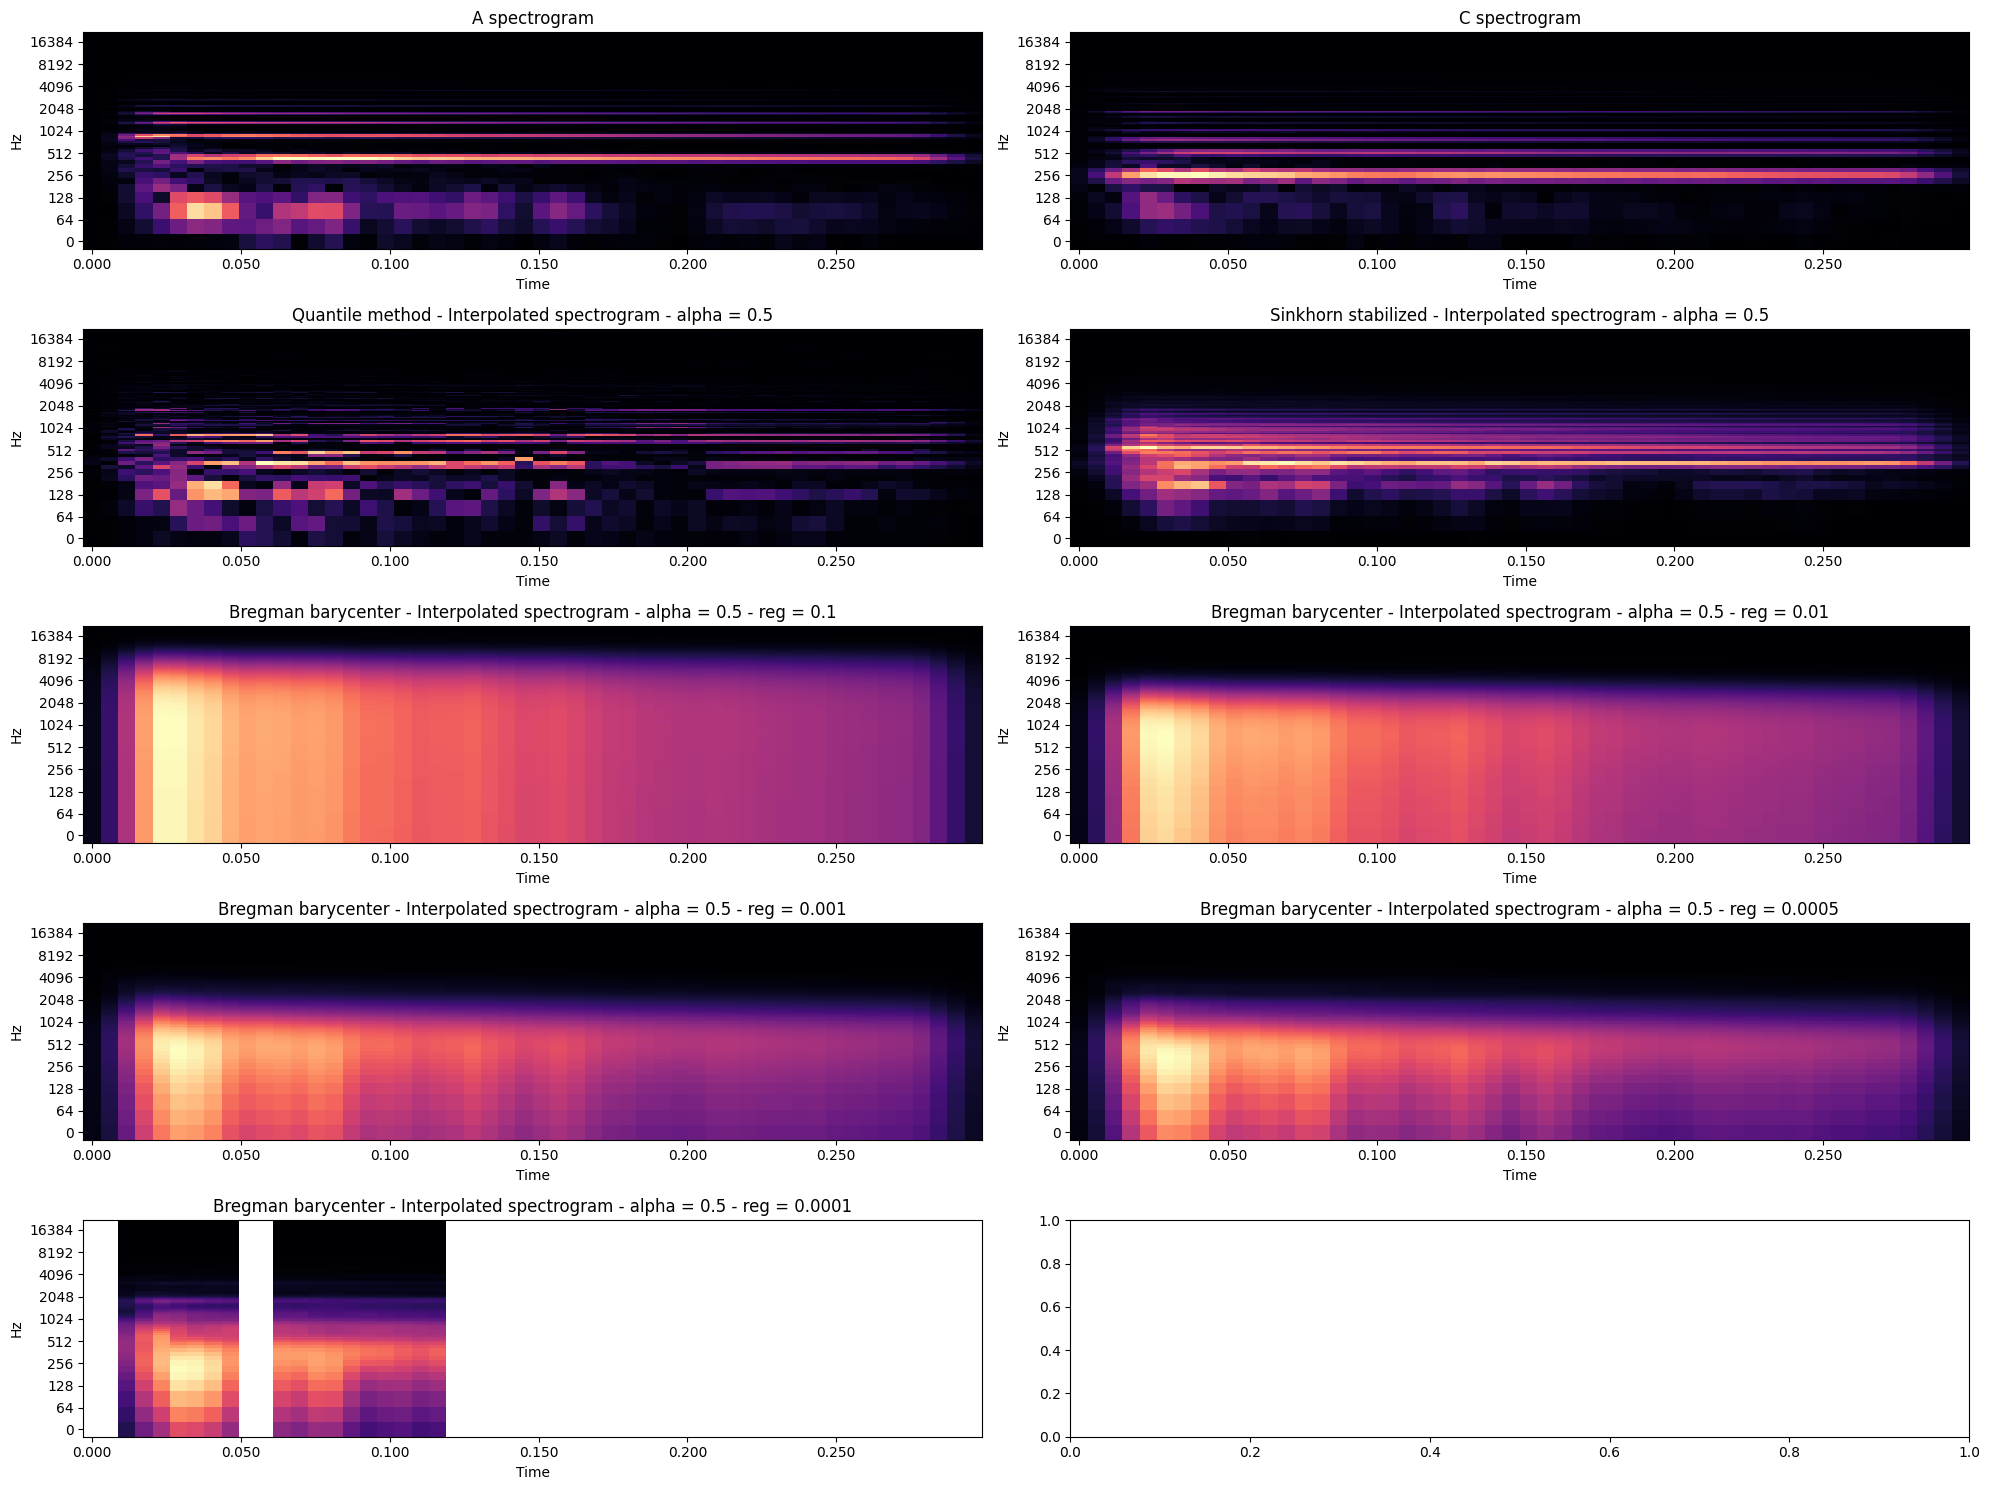

In [471]:
index = 0
quantile_interpolation = quantile_interpolations[index]
ss_interpolation = ss_interpolations[index]
bb_interpolation = bb_interpolations[index]

fig, ax = plt.subplots(2 + len(bb_regs)//2 + 1, 2, figsize=(20, 15))

librosa.display.specshow(np.abs(A_fft), y_axis='log', x_axis='time', ax=ax[0][0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(np.abs(C_fft), y_axis='log', x_axis='time', ax=ax[0][1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(np.abs(quantile_interpolation), y_axis='log', x_axis='time', ax=ax[1][0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(np.abs(ss_interpolation), y_axis='log', x_axis='time', ax=ax[1][1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)

ax[0][0].set_title(f'A spectrogram')
ax[0][1].set_title(f'C spectrogram')
ax[1][0].set_title(f'Quantile method - Interpolated spectrogram - alpha = {alpha_arr[index]}')
ax[1][1].set_title(f'Sinkhorn stabilized - Interpolated spectrogram - alpha = {alpha_arr[index]}')

for i, spec in enumerate(bb_interpolations[index]):
    librosa.display.specshow(np.abs(spec), y_axis='log', x_axis='time', ax=ax[2+i//2][i%2], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
    ax[2+i//2][i%2].set_title(f'Bregman barycenter - Interpolated spectrogram - alpha = {alpha_arr[index]} - reg = {bb_regs[i]}')

plt.tight_layout()

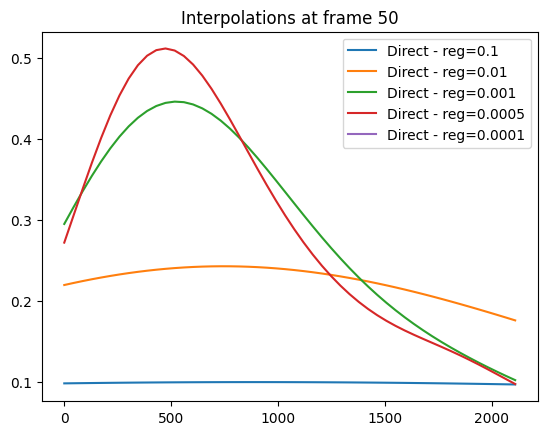

In [487]:
# # SLIDES - PLOTS

# alpha_index = 0
# quantile_interpolation = quantile_interpolations[alpha_index]
# ss_interpolation = ss_interpolations[alpha_index]
# bb_interpolation = bb_interpolations[alpha_index]
# frame = 50

# n_frames = 50

# # plt.plot(freqs[:n_frames], np.abs(A_fft[:, frame][:n_frames]), label=f"A")
# # plt.plot(freqs[:n_frames], np.abs(C_fft[:, frame][:n_frames]), label=f"C")
# # plt.plot(freqs[:n_frames], np.abs(quantile_interpolation[:, frame][:n_frames]), label=f"Quantile")
# # plt.plot(freqs[:n_frames], np.abs(ss_interpolation[:, frame][:n_frames]), label=f"Sinkhorn stabilized")

# for i, spec in enumerate(bb_interpolation):
#     plt.plot(freqs[:n_frames], np.abs(spec[:, frame][:n_frames]), label=f"Direct - reg={bb_regs[i]}")

# plt.legend()
# plt.title(f"Interpolations at frame {frame}")  
# plt.show()  

In [473]:
index = 0
quantile_interpolation = quantile_interpolations[index]
ss_interpolation = ss_interpolations[index]
bb_interpolation = bb_interpolations[index]

quantile_inversed = librosa.griffinlim(quantile_interpolation, n_iter=100)
ss_inversed = librosa.griffinlim(ss_interpolation, n_iter=100)
bb_inversed = [librosa.griffinlim(bb_interpolation[i], n_iter=100) for i in range(len(bb_interpolation) - 2)]
audio_widgets = []

title = widgets.Label(f'A')
audio_player = IPython.display.Audio(data=A4_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C')
audio_player = IPython.display.Audio(data=C5_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Quantile interpolation - alpha={alpha_arr[index]}')
audio_player = IPython.display.Audio(data=quantile_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'Sinkhorn interpolation - alpha={alpha_arr[index]}')
audio_player = IPython.display.Audio(data=ss_inversed, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

for i, reg_interpolation in enumerate(bb_inversed): 
    title = widgets.Label(f'Bregman barycenter interpolation - alpha={alpha_arr[index]} - reg={bb_regs[i]}')
    audio_player = IPython.display.Audio(data=reg_interpolation, rate=sr)
    out = widgets.Output()
    with out:
        display(audio_player)
    combined_widget = widgets.VBox([title, out])
    audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

# Draft

In [474]:
duration = 0.3 # in seconds

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)


A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)

n_fft = 1024
A_fft = librosa.stft(A_signal, n_fft=n_fft)
C_fft = librosa.stft(C_signal, n_fft=n_fft)

freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)


In [475]:
index = np.random.randint(0, A_fft.shape[1])

A_frame = A_fft[:,index]
A_frame = np.abs(A_frame)
A_frame_relative_amplitude = np.sum(A_frame)
a1 = A_frame / np.sum(A_frame)
C_frame = C_fft[:,index]
C_frame = np.abs(C_frame)
C_frame_relative_amplitude = np.sum(C_frame)
a2 = C_frame / np.sum(C_frame)

_up_to = 100

n = _up_to
frequencies = np.arange(_up_to)


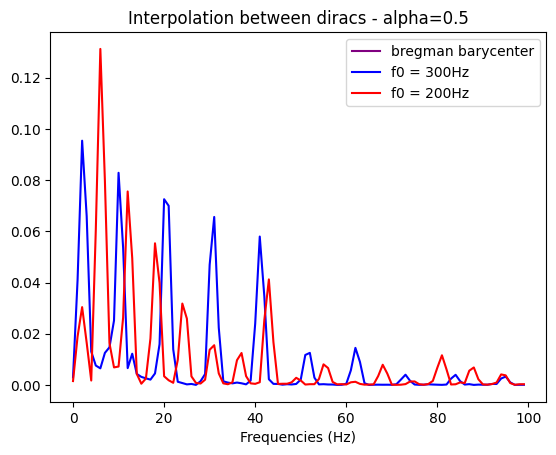

In [476]:
# Optimal transport

alpha = 0.5

# # Quantile method 

# quantile_interpolation = quantile_optimal_transport(a1, a2, alpha=alpha)

# # ot.bregman.sinkhorn_stabilized

M = ot.utils.dist0(n) # cost matrix
M /= M.max()
# reg = 1e-2

# ot_plan = ot.bregman.sinkhorn_stabilized(a1, a2, M, reg)

# ss_interpolation = np.zeros(n)
# for i in range(n):
#     for j in range(n):
#         index = get_frequency(i, j, alpha=alpha, method='int')
#         ss_interpolation[index] += ot_plan[i][j]
# ss_interpolation /= np.sum(ss_interpolation)

# ot.bregman.barycenter

A = np.vstack((a1[:_up_to], a2[:_up_to])).T
weights = np.array([1 - alpha, alpha])
bb_reg = 5e-5
bregman_interpolation = ot.bregman.barycenter(A, M, bb_reg, weights)

# plt.plot(frequencies[:_up_to], quantile_interpolation[:_up_to], label='Quantile', color="orange")
plt.plot(frequencies[:_up_to], bregman_interpolation[:_up_to], label='bregman barycenter', color="purple")
# plt.plot(frequencies[:_up_to], ss_interpolation[:_up_to], label='sinkhorn_stabilized', color="green")
plt.plot(frequencies[:_up_to], a1[:_up_to], label=f"f0 = {f1:.0f}Hz", color="blue")
plt.plot(frequencies[:_up_to], a2[:_up_to], label=f"f0 = {f2:.0f}Hz", color="red")
plt.xlabel("Frequencies (Hz)")
plt.title(f"Interpolation between diracs - alpha={alpha}")
plt.legend()
plt.show()
